# Swept source control
## Required instruments
1. RedPitaya 
2. DiCon FiberOptic Switch connected by serial cable

## Setting up hardware
### RedPitaya

https://redpitaya.readthedocs.io/en/latest/appsFeatures/remoteControl/remoteControl.html#python



In [2]:
# Blink test
import sys
import time
import redpitaya_scpi as scpi

rp_s = scpi.scpi('10.138.7.215')

led = 0

print ("Blinking LED["+str(led)+"]")

period = 1 # seconds

for i in range(10):
    time.sleep(period/2.0)
    rp_s.tx_txt('DIG:PIN LED' + str(led) + ',' + str(1))
    time.sleep(period/2.0)
    rp_s.tx_txt('DIG:PIN LED' + str(led) + ',' + str(0))

Blinking LED[0]


rp-f08358.local has IP 10.138.7.215 is connected
Setting signal generation parameters for rp-f08358.local
Setting signal acquisition parameters for rp-f08358.local
turn on output and start acquisition
turn off output and finish acquisition


C:\Users\T5810\.conda\envs\py36\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\T5810\.conda\envs\py36\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\T5810\.conda\envs\py36\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


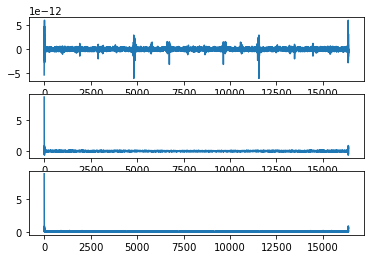

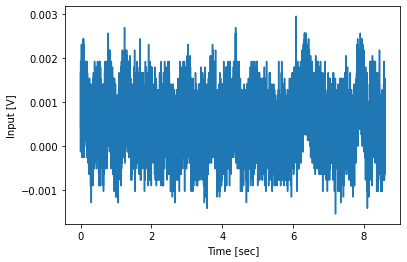

rp-f08358.local with IP 10.138.7.215 successfully disconnected


In [15]:
import sys
import redpitaya_scpi as scpi
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
import socket

fiber_channel = {
    'rp-f08358.local': 0,
#     'rp-f08473.local': 1,
}
# fiber_channel['rp-f08473.local']

ip = {}
rp_s = {}

for (hostname,channel) in fiber_channel.items():
    # Get IP and connect to scpi server
    try:
        ip.update({hostname : socket.gethostbyname(hostname)})        
        rp_s.update({hostname : scpi.scpi(ip[hostname])})
    except:
        print('{} is unavailable: {}'.format(hostname, sys.exc_info()))
    else:
        print('{} has IP {} is connected'.format(hostname, ip[hostname]))

# Measurement parameters
integration_time = 5.0 # sec
if integration_time > 8.5 :
    print('integration time needs to be smaller than 8.5 sec')
    exit()
# Modulation parameters.
wave_form = 'sine'
freq = 500
ampl = 0.5
offset = 0.5

sampling_rate = 125e6 #sample/s
total_samples = 16384
# determine decimation rate
decimation_options = np.array([1,8,64,1024,8192,65536])
measurement_length = total_samples / sampling_rate * decimation_options
decimation = decimation_options[np.argmax(measurement_length >=integration_time)]
sampling_freq = sampling_rate/decimation



# Initializing singal generation and acquisition parameters
for (hostname,rp) in rp_s.items():           
    print('Setting signal generation parameters for {}'.format(hostname))
    rp.tx_txt('GEN:RST')
    rp.tx_txt('SOUR1:FUNC' + str(wave_form).upper())
    rp.tx_txt('SOUR1:FREQ:FIX' + str(freq))
    rp.tx_txt('SOUR1:VOLT ' + str(ampl))
    rp.tx_txt('SOUR1:VOLT:OFFS ' + str(offset))
    
    print('Setting signal acquisition parameters for {}'.format(hostname))
    rp.tx_txt('ACQ:RST')
    rp.tx_txt('ACQ:AVG OFF') # turn off averaging        
    rp.tx_txt('ACQ:SOUR1:COUP DC') # enables DC coupling on channel 1
    rp.tx_txt('ACQ:SOUR1:GAIN LV') # set high voltage gain settings
  
   
    # Acquire signal
    print('turn on output and start acquisition')
    rp.tx_txt('OUTPUT1:STATE ON')
    rp.tx_txt('ACQ:START')
    rp.tx_txt('ACQ:TRIG NOW') # set to trigger immediately
    sleep(integration_time)
    
    print('turn off output and finish acquisition')
    rp.tx_txt('ACQ:STOP')
    rp.tx_txt('OUTPUT1:STATE OFF')
    

    rp.tx_txt('ACQ:SOUR1:DATA?')
    buff_string = rp.rx_txt()
#     print(buff_string)
#     buff_string = buff_string.strip('ERR!{}\n\r').replace("  ", "").split(',')
    buff_string = buff_string.strip('ERR!{}\n\r').split(',')
#     print(buff_string)
    buff = list(map(float, buff_string))
    
time = np.arange(0, len(buff), 1)/sampling_freq

demod_sin = np.sin(2*np.pi*sampling_freq*time)*np.array(buff)
demod_cos = np.cos(2*np.pi*sampling_freq*time)*np.array(buff)

fft_demod_sin = np.fft.fft(demod_sin)
fft_demod_cos = np.fft.fft(demod_cos)
# A = np.mean(demod_sin)
# B = np.mean(demod_cos)

fft_demod_mag = np.sqrt(fft_demod_sin**2 + fft_demod_cos**2)

plt.figure()
plt.subplot(311)
plt.plot(fft_demod_sin)

plt.subplot(312)
plt.plot(fft_demod_cos)

plt.subplot(313)
plt.plot(fft_demod_mag)


plt.figure()
plt.plot(time,buff)
plt.ylabel('Input [V]')
plt.xlabel('Time [sec]')

plt.show()


# plt.figure()
# plt.plot(time,buff)
# plt.xlim([0, 10/freq])
# plt.show()


# Close connections
for (hostname,channel) in rp_s.items():           
    try:        
        rp_s[hostname].close()
    except:
        print('Could not close {}: {}'.format(hostname, sys.exc_info()))
    else:
        print('{} with IP {} successfully disconnected'.format(hostname, ip[hostname]))